# Description 

A company has a lot of client data in  word, pdf, images etc. containing different types of graphs. They want to have this data stored in their database. 

They approached you with a dataset of extracted plots of different types, and want you to: 

__Classify images of plots into different classes: (2pts)__

You are provided with a dataset.zip, containing images of different types of plots.  
Tasks: 

a) Clean the dataset (remove any file which is corrupted, make sure images are in 
same format (.jpg or .png )) 

b) Build a classifier training code (pytorch or keras or classical ML  model anything is 
fine) 

c) Do the accuracy metrics analysis 

d) Save model 

e) Inference code testing your model on any image from the dataset 


__Deliverables:__
1. Complete code or notebook 
2. Saved model file 
3. Documentation containing instructions to run your code and a requirements.txt (You can also make use of Markdown cells if you are using a notebook)

In [1]:
# Add all the needed imports
import keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau

import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

### Split the data

In [2]:
image_dir = 'dataset_part1_split'
image_size = 256

In [3]:
# Setup a generator for training
# Training images
train_image_datagen = ImageDataGenerator(rescale=1./255)

train_image_generator = train_image_datagen.flow_from_directory(
    f'{image_dir}/train',
    target_size=(image_size, image_size),
    batch_size=16,
    class_mode="categorical",
    color_mode='grayscale',
    seed=42)

# val images
val_image_datagen = ImageDataGenerator(rescale=1./255)

val_image_generator = val_image_datagen.flow_from_directory(
    f'{image_dir}/val',
    target_size=(image_size, image_size),
    batch_size=16,
    class_mode="categorical",
    color_mode='grayscale',
    seed=42
)

Found 3059 images belonging to 5 classes.
Found 1147 images belonging to 5 classes.


In [4]:
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [5]:
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-6
)

In [6]:
def simple_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D())
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))  # softmax for multi-class classification

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1])
    model.summary()
    return model

# Build model
input_shape = (image_size, image_size, 1)  # grayscale
num_classes = train_image_generator.num_classes
model = simple_cnn_model(input_shape, num_classes)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 246016)            0         
                                                                 
 dense (Dense)               (None, 128)               3

In [7]:
# EarlyStopping()
from keras.callbacks import EarlyStopping
cb = EarlyStopping(monitor='val_loss',
                   patience=10,
                   restore_best_weights='True',
                   mode='min')

In [8]:
# This is where the magic happens
history = model.fit(
    train_image_generator,
    steps_per_epoch=len(train_image_generator),
    epochs=30,
    validation_data = val_image_generator,
    validation_steps = val_image_generator.samples//16,
    callbacks=[cb, lr_scheduler]
)

Epoch 1/30
192/192 [==============================] - 15s 57ms/step - loss: 1.6044 - accuracy: 0.4119 - f1: 0.1901 - val_loss: 1.2182 - val_accuracy: 0.6127 - val_f1: 0.2889 - lr: 0.0010
Epoch 2/30
192/192 [==============================] - 6s 29ms/step - loss: 0.9478 - accuracy: 0.6469 - f1: 0.5522 - val_loss: 0.5662 - val_accuracy: 0.8292 - val_f1: 0.7613 - lr: 0.0010
Epoch 3/30
192/192 [==============================] - 5s 28ms/step - loss: 0.6426 - accuracy: 0.7764 - f1: 0.7379 - val_loss: 0.6330 - val_accuracy: 0.8310 - val_f1: 0.7259 - lr: 0.0010
Epoch 4/30
192/192 [==============================] - 5s 27ms/step - loss: 0.4485 - accuracy: 0.8486 - f1: 0.8273 - val_loss: 0.2908 - val_accuracy: 0.9093 - val_f1: 0.9089 - lr: 0.0010
Epoch 5/30
192/192 [==============================] - 5s 28ms/step - loss: 0.2523 - accuracy: 0.9176 - f1: 0.9115 - val_loss: 0.1860 - val_accuracy: 0.9463 - val_f1: 0.9456 - lr: 0.0010
Epoch 6/30
192/192 [==============================] - 5s 28ms/step - 

## c) Do the accuracy metrics analysis 

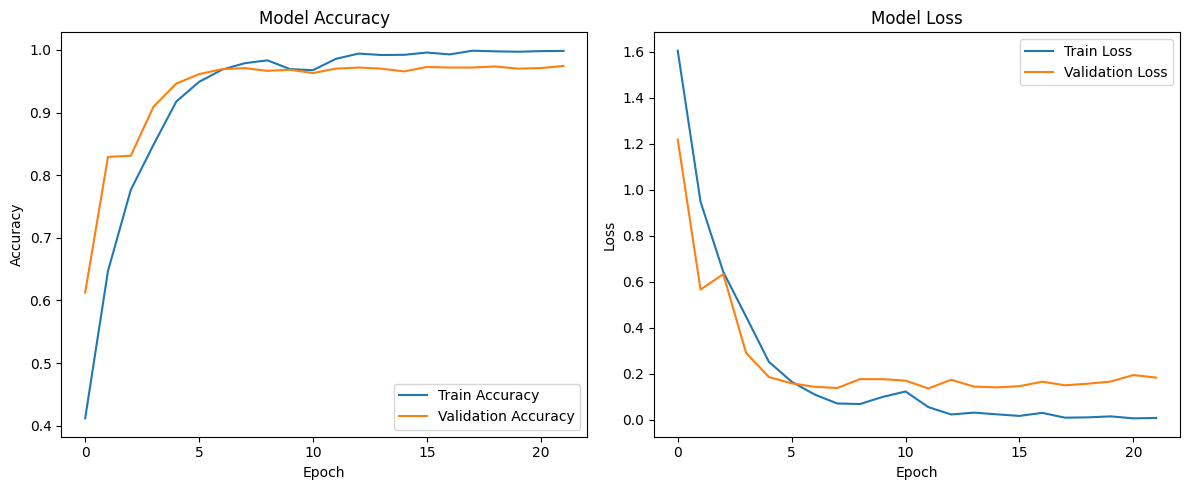

In [9]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

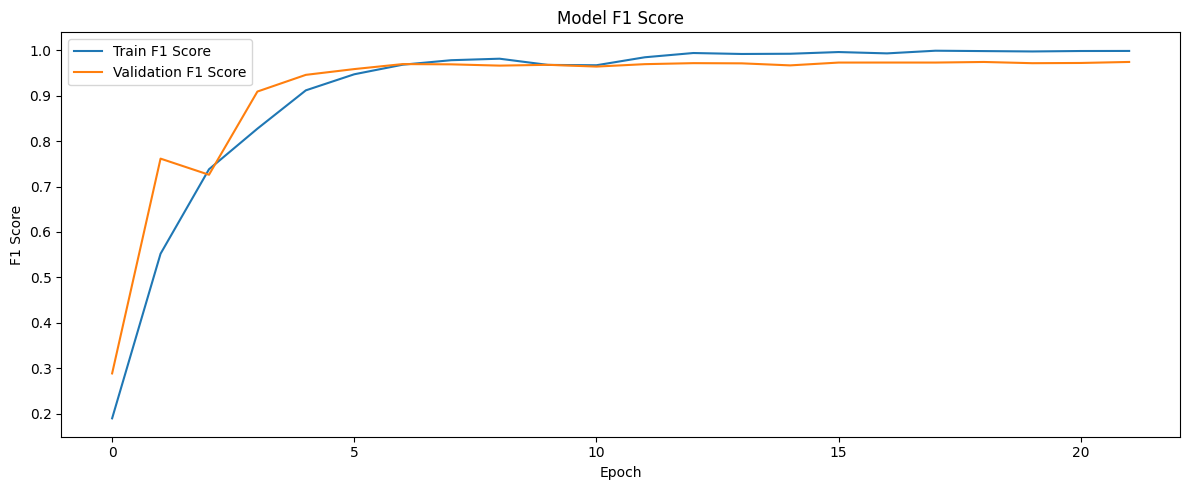

In [10]:
# Plot the validation f1 score
plt.figure(figsize=(12, 5))
plt.plot(history.history['f1'], label='Train F1 Score')
plt.plot(history.history['val_f1'], label='Validation F1 Score')
plt.title('Model F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.tight_layout()
plt.show()

72/72 [==============================] - 49s 660ms/step


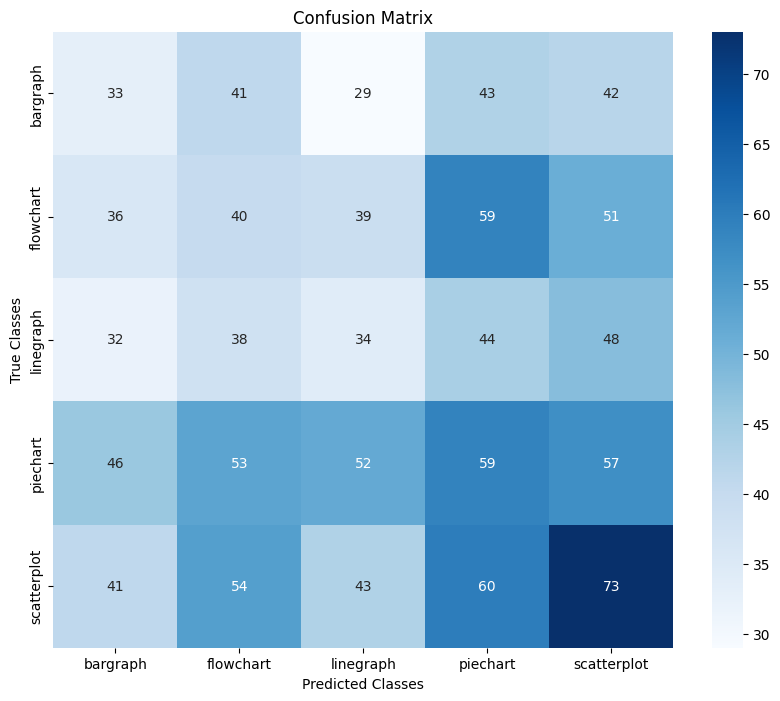

In [14]:
# Get predictions
val_predictions = model.predict(val_image_generator)
val_pred_classes = np.argmax(val_predictions, axis=1)
val_true_classes = val_image_generator.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(val_true_classes, val_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=val_image_generator.class_indices.keys(), yticklabels=val_image_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

## d) Save model 

In [12]:
# Save the model
model.save('simple_cnn_model_v1.h5')